# Workflow for Geodata preparation for palmpy

DWD Tutorial: Process Geodata in Python!

What we need: Amtliche Vermessungsdaten, Gebäudealter

<br>



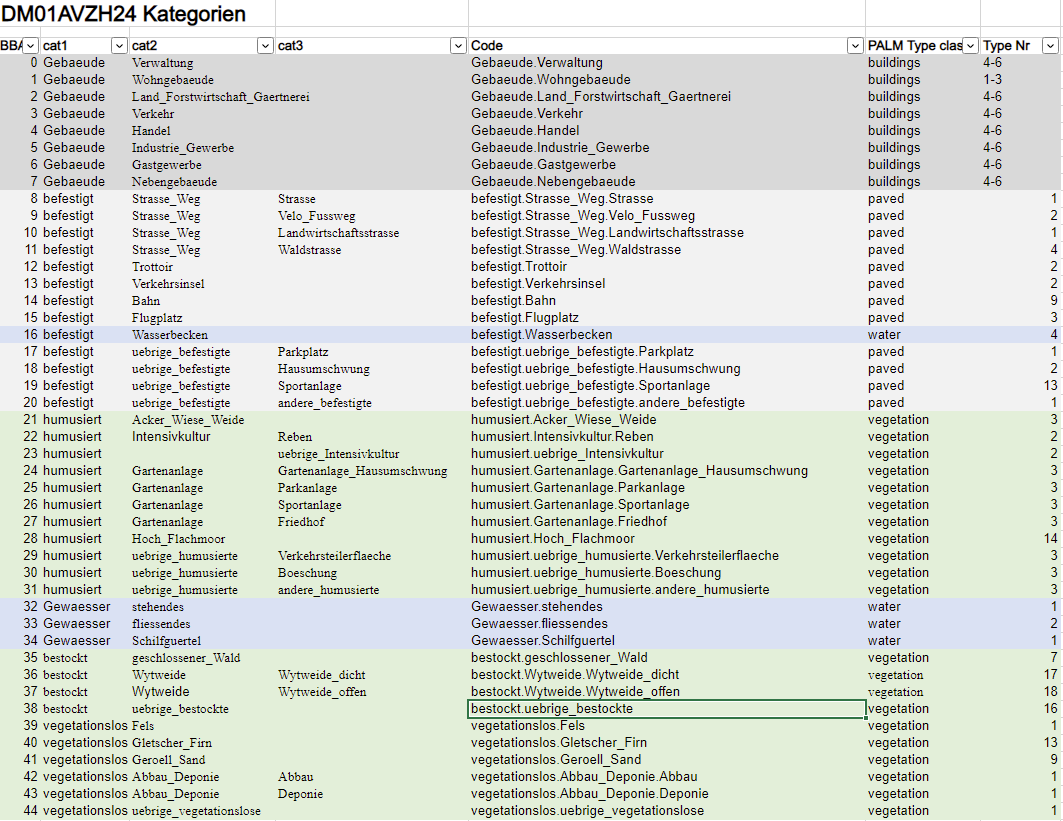

<hr>

In [2]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

Import the AV dataset as shapefile.

In [3]:
gdf = gpd.read_file(r'I:\Geodaten\DWD_palmpy_tutorial\AV_Kanton_Zürich_DM01AVZH24_Bo_BoFlaeche_A_zuschnitt.shp') # if you have a huge dataset, define a bounding box with keyword bbox=(2689036,1255050,2705997,1268854)

Check if total bounds are reasonable. Here they match EPSG2056 or LV95 standards, and they are not NaN. So all good, yay.

In [4]:
gdf.total_bounds

array([2682736.379, 1246207.213, 2684212.81 , 1247871.038])

Have a sneek peek at the columns in it. ART and ART_TXT are what we look for as description of the surface.

In [5]:
gdf.columns

Index(['OBJID', 'ENTSTEHUNG', 'QUALITAET', 'QUALITAET_', 'ART', 'ART_TXT',
       'R1_OBJID', 'R1_NBIDENT', 'R1_IDENTIF', 'R1_BESCHRE', 'R1_GUELTIG',
       'R1_GUELTI1', 'R1_GUELTI2', 'R1_DATUM1', 'geometry'],
      dtype='object')

So which ART's are in there??

In [6]:
np.sort(gdf.ART.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 16, 17, 18, 19,
       20, 24, 25, 26, 27, 29, 31, 32, 33, 38], dtype=int64)

What does that mean in text form?

In [7]:
np.sort(gdf.ART_TXT.unique())

array(['Gebaeude.Gastgewerbe', 'Gebaeude.Handel',
       'Gebaeude.Industrie_Gewerbe',
       'Gebaeude.Land_Forstwirtschaft_Gaertnerei',
       'Gebaeude.Nebengebaeude', 'Gebaeude.Verkehr',
       'Gebaeude.Verwaltung', 'Gebaeude.Wohngebaeude',
       'Gewaesser.fliessendes', 'Gewaesser.stehendes', 'befestigt.Bahn',
       'befestigt.Strasse_Weg.Strasse',
       'befestigt.Strasse_Weg.Velo_Fussweg', 'befestigt.Trottoir',
       'befestigt.Verkehrsinsel', 'befestigt.Wasserbecken',
       'befestigt.uebrige_befestigte.Hausumschwung',
       'befestigt.uebrige_befestigte.Parkplatz',
       'befestigt.uebrige_befestigte.Sportanlage',
       'befestigt.uebrige_befestigte.andere_befestigte',
       'bestockt.uebrige_bestockte', 'humusiert.Gartenanlage.Friedhof',
       'humusiert.Gartenanlage.Gartenanlage_Hausumschwung',
       'humusiert.Gartenanlage.Parkanlage',
       'humusiert.Gartenanlage.Sportanlage',
       'humusiert.uebrige_humusierte.Verkehrsteilerflaeche',
       'humusiert.uebr

So: we can split them now based on the table on top into everything we need: Building types, BB (Bodenbedeckung) types and pavement types.

In [8]:
bldg_types = [0,1,2,3,4,5,6,7]
bb_types = [16,21,22,23,24,25,26,27,28,29,30,31,35,36,37,38,39,40,41,42,43,44,32,33,34]
pav_types = [8,9,10,11,12,13,14,15,17,18,19,20]

Seperate into different dataframes

In [9]:
bldgs = gdf[gdf.ART.isin(bldg_types)]
bb = gdf[gdf.ART.isin(bb_types)]
pav = gdf[gdf.ART.isin(pav_types)]

Plot them to see if we did well:

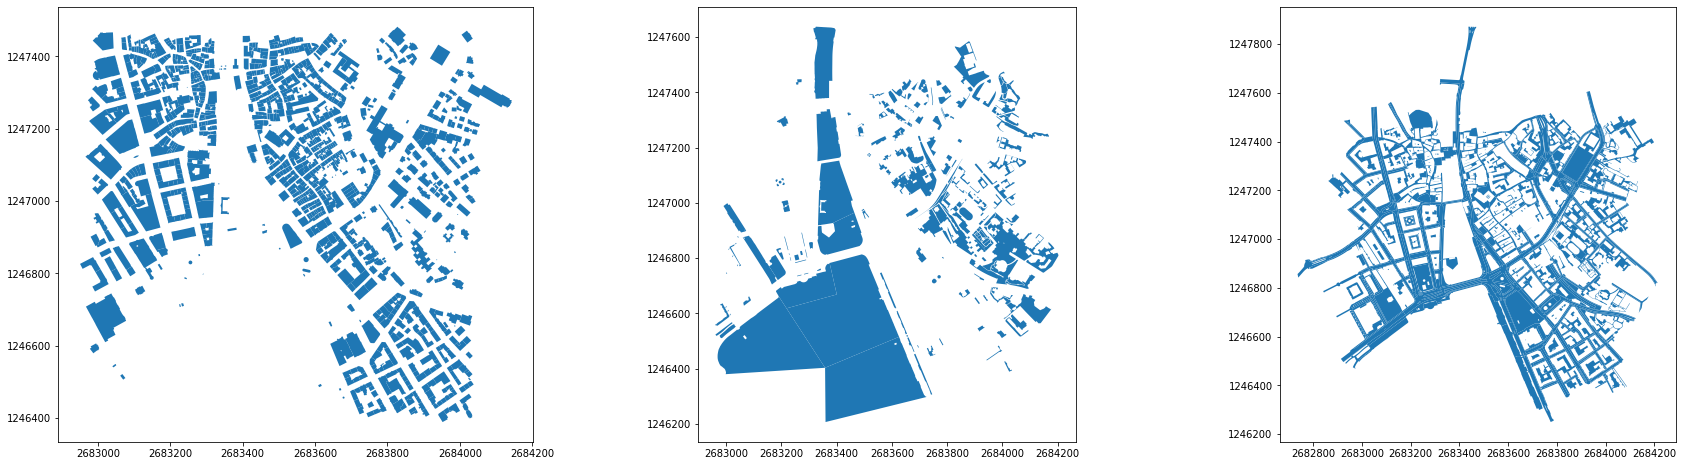

In [10]:
fig,ax = plt.subplots(1,3, figsize=(30,8))
bldgs.plot(ax=ax[0])
bb.plot(ax=ax[1])
pav.plot(ax=ax[2])

Do you need a popup to zoom around in? use qt:

In [21]:
#%matplotlib qt

plot buildings only to look at them

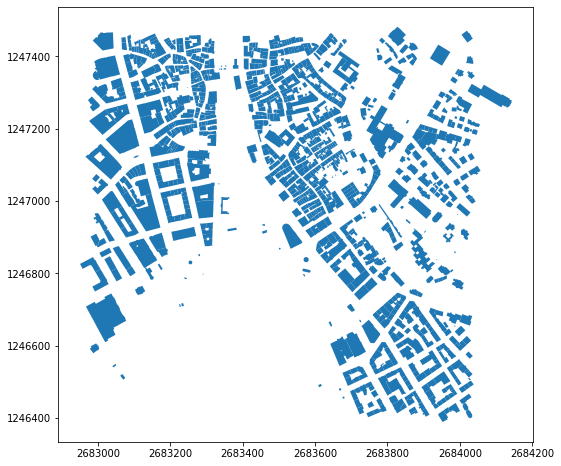

In [11]:
bldgs.plot()

Rename ART to BELAGSART in the pavement file and in the bb filte to OBJEKTART. It has been a requirement in palmpy, not any more, but I am doing it for backwards compatibility now.

In [12]:
pav = pav.rename(columns={'ART':'BELAGSART'})

In [13]:
bb = bb.rename(columns={'ART':'OBJEKTART'})

Set CRS to LV95 - the coordinates are in this coordinate system, but it just has not been set yet. With this, you declare the coordinates are in LV95. If you write WGS84, it won't complain, but it'll be wrong! You have to know the source CRS here.

In [14]:
pav.crs = {'init' :'epsg:2056'}
bldgs.crs = {'init' :'epsg:2056'}
bb.crs = {'init' :'epsg:2056'}

C:\Users\Stefan Fluck\Miniconda3\envs\palm\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Tip: some geometries may be not closed, self intersecting, etc. You can solve that by creating a 0 distance buffer - which will basically rewrite the geometry into something valid.

In [15]:
bb.geometry = bb.geometry.buffer(0)
bldgs.geometry = bldgs.geometry.buffer(0)
pav.geometry = pav.geometry.buffer(0)

C:\Users\Stefan Fluck\Miniconda3\envs\palm\lib\site-packages\geopandas\geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


Save it! (Commented as I already did it before)

In [27]:
#pav.to_file('I:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_paved_surfaces.shp')
#bldgs.to_file('I:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_building_surfaces.shp')
#bb.to_file('I:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_vegetation_surfaces.shp')

In [20]:
bldgs

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry
63,99784,BBNachfuehrung[8219],0,AV93,4,Gebaeude.Handel,8219,ZH0200000261,30036,"Sechseläuten, Bellevueplatz",1,gueltig,20171025,-99,"POLYGON ((2683570.035 1246791.096, 2683566.504..."
102,49286,BBNachfuehrung[9300],0,AV93,0,Gebaeude.Verwaltung,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684027.769 1246655.516, 2684020.250..."
136,95228,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684003.160 1246655.412, 2684015.278..."
138,96243,BBNachfuehrung[6896],0,AV93,7,Gebaeude.Nebengebaeude,6896,ZH0200000261,29524,"Kreuzbühlstrasse 16, 20, 26",1,gueltig,20160708,-99,"POLYGON ((2683986.611 1246652.465, 2683985.440..."
140,95229,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684031.197 1246614.074, 2684018.828..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,683,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2683706.805 1247140.648, 2683706.679..."
2089,540,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683647.084 1247289.674, 2683643.669..."
2090,536,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683534.182 1247321.479, 2683533.506..."
2091,1840,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683633.134 1247297.933, 2683630.110..."


<hr>

## Process the Buildings

The buildings dataset does not contain height in the AV dataset. But we have the LoD1 dataset.

In [22]:
bldlod1 = gpd.read_file(r'I:\Geodaten\DWD_palmpy_tutorial\lod1_gebaeude_max_3d_kantonzuerich_zuschnitt.shp') 

In [23]:
bldlod1.columns

Index(['adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt', 'gid_3d',
       'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau', 'h_rel_firs',
       'h_rel_mean', 'ogid', 'otype', 'qumess', 'sta', 'wichtig', 'geometry'],
      dtype='object')

Plot it by height column (mean).

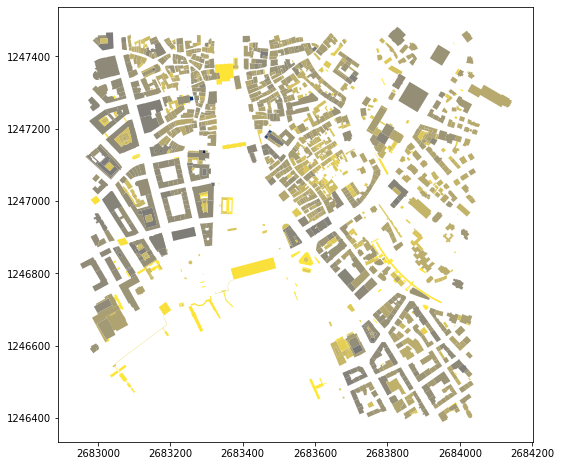

In [24]:
bldlod1.plot(column='h_rel_mean', cmap='cividis_r')

According to the palmpy documentation, you'll need a few attirbutes: HEIGHT_TOP, HEIGHT_BOT, ID, BLDGTYP. The first three are easy - the BLDGTYP requires some work.
Is year in the bld dataset?

In [25]:
bldlod1

,adat,art,ausr,bem,dach,edat,egid,filt,gid_3d,h_boden,...,h_mean,h_rel_trau,h_rel_firs,h_rel_mean,ogid,otype,qumess,sta,wichtig,geometry
0,20140925,0,BATCHUSER,OK,NaN,20090101,140856.0,08,z41ac39cc00001bb0-00-0001,404.8,...,424.95,16.6,23.7,20.15,z41ac39cc00001bb0,BB,None,real,None,"POLYGON ((2683326.581 1247163.424, 2683326.252..."
1,20140925,1,BATCHUSER,OK,NaN,20090101,140848.0,08,z41ac39cc00001bb3-00-0001,404.9,...,422.85,16.1,19.8,17.95,z41ac39cc00001bb3,BB,None,real,None,"POLYGON ((2683315.731 1247196.243, 2683308.974..."
2,20140925,7,BATCHUSER,OK,NaN,20090101,302040085.0,08,z41ac39cc0000196e-00-0001,405.1,...,419.90,13.2,16.4,14.80,z41ac39cc0000196e,BB,None,real,None,"POLYGON ((2683442.768 1247237.870, 2683435.881..."
3,20140925,7,BATCHUSER,OK,NaN,20090101,302020715.0,08,z41ac39cc00001970-00-0001,413.6,...,424.20,10.6,10.6,10.60,z41ac39cc00001970,BB,None,real,None,"POLYGON ((2683559.524 1247128.937, 2683554.815..."
4,20140925,1,BATCHUSER,OK,NaN,20090101,140498.0,08,z41ac39cc00001972-00-0001,425.1,...,433.25,6.3,10.0,8.15,z41ac39cc00001972,BB,None,real,None,"POLYGON ((2683664.574 1247086.001, 2683657.552..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,20210720,0,GEORUR,OK,3000.0,20110819,9011091.0,08,z41ac69e900023244-00-0002,404.7,...,430.10,24.0,26.8,25.40,z41ac69e900023244,BB,None,real,None,"POLYGON ((2682998.683 1246690.120, 2682988.509..."
1472,20210720,0,GEORUR,OK,6000.0,20110819,9011091.0,08,z41ac69e900023244-00-0004,404.7,...,423.20,18.5,18.5,18.50,z41ac69e900023244,BB,None,real,None,"POLYGON ((2682995.775 1246712.435, 2682994.005..."
1473,20220215,8,BATCHUSER,OKMESS,NaN,20121005,NaN,08,z41ac437000005e7c-01-0001,406.8,...,408.80,2.0,2.0,2.00,z41ac437000005e7c,EO,None,real,None,"POLYGON ((2683006.534 1247000.477, 2683004.690..."
1474,20210720,3,GEORUR,OKMESS,6000.0,20210720,9011091.0,08,z55c9d3b4aef3002f-00-0001,419.6,...,419.90,0.3,0.3,0.30,z55c9d3b4aef3002f,EO,None,real,None,"POLYGON ((2683031.163 1246613.674, 2683020.865..."


No. It's also not in the AV dataset. But, there is an OGD Dataset from Zurich! WFS link https://maps.zh.ch/wfs/OGDZHWFS  
download and open it:

In [26]:
gebalter = gpd.read_file(r'I:\Geodaten\DWD_palmpy_tutorial\Gebaeudealter_Flaechen.shp') 

What info do we have in it?

In [27]:
gebalter.columns

Index(['objid', 'qualitaet', 'art', 'gwr_egid', 'bfsnr', 'bearbeitun',
       'artchid', 'artzhid', 'artzh', 'gvznummer', 'egid', 'ggdenr', 'gkat',
       'gbauj', 'gbaup', 'dkode', 'dkodn', 'stichtag', 'geodb_oid',
       'geometry'],
      dtype='object')

What does it say? So we have an oldest building of 1100 (really?) and newest of 2019. Sounds reasonable.

In [30]:
gebalter.gbauj.describe()

count    1111.000000
mean     1802.054905
std       186.230535
min      1100.000000
25%      1800.000000
50%      1857.000000
75%      1929.000000
max      2019.000000
Name: gbauj, dtype: float64

now lets see, do we have matching columns maybe on which we can match the lod1 dataset with heights with the year dataset?

In [32]:
print(gebalter.columns)
print(bldlod1.columns)

Index(['objid', 'qualitaet', 'art', 'gwr_egid', 'bfsnr', 'bearbeitun',
       'artchid', 'artzhid', 'artzh', 'gvznummer', 'egid', 'ggdenr', 'gkat',
       'gbauj', 'gbaup', 'dkode', 'dkodn', 'stichtag', 'geodb_oid',
       'geometry'],
      dtype='object')
Index(['adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt', 'gid_3d',
       'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau', 'h_rel_firs',
       'h_rel_mean', 'ogid', 'otype', 'qumess', 'sta', 'wichtig', 'geometry'],
      dtype='object')


Oh look, there's an ogid! are they the same though?? check in GIS! -> yes they match! merge them on the column "egid"

In [103]:
bld_comb = gpd.sjoin(bldlod1, gebalter[['geometry', 'gbauj', 'artzh']], how='left')

In [104]:
bld_comb.columns

Index(['adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt', 'gid_3d',
       'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau', 'h_rel_firs',
       'h_rel_mean', 'ogid', 'otype', 'qumess', 'sta', 'wichtig', 'geometry',
       'index_right', 'gbauj', 'artzh'],
      dtype='object')

set nan in gbauj column to 1980. Just a guess.

In [105]:
bld_comb.gbauj.isna().sum() #we have 64 buildings without a year ouf of over 3500. that's good.

bld_comb.loc[bld_comb.gbauj.isna(), 'gbauj'] = 1980

PLot the Baujahr to see if it is reasonable. Older buildings are in the old part, so that's cool.

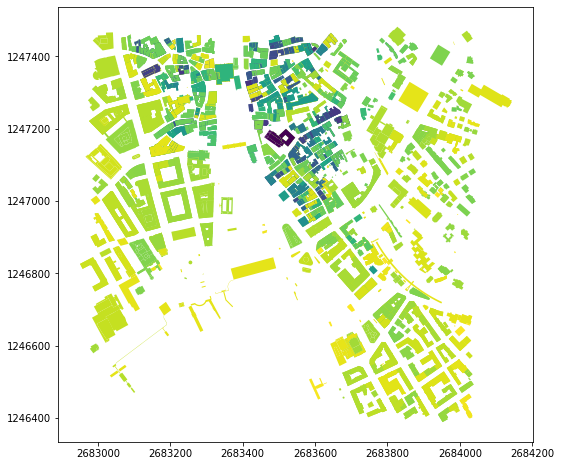

In [106]:
bld_comb.plot(column='gbauj')

Now we have the Baujahr and the usage in column artzh. What is all in artzh?

In [107]:
bld_comb.artzh.unique()

array(['Gebäude Wohnen', 'Gebäude Verwaltung', 'Nebengebäude',
       'Gebäude Handel', 'Gebäude Gastgewerbe', 'Gebäude Industrie',
       'Gebäude Verkehrswesen', 'Gebäude Landwirtschaft', nan],
      dtype=object)

Great we can use that to make the Building type. So our residential buildings are called "Gebäude Wohnen". all others are office spaces. So lets work with that!

In [108]:
def classify_bldgtyp(gdf, name_typecol = 'artzh', name_jahrcol = 'gbauj', name_wohngebaeude = 'Gebäude Wohnen'):
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] < 1950), "BLDGTYP"] = 1
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] >= 1950) & (gdf[name_jahrcol] < 2000), "BLDGTYP"] = 2
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] >= 2000), "BLDGTYP"] = 3
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] < 1950), "BLDGTYP"] = 4
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] >= 1950) & (gdf[name_jahrcol] < 2000), "BLDGTYP"] = 5
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] >= 2000), "BLDGTYP"] = 6
    return gdf

Create a new column

In [109]:
bld_comb['BLDGTYP'] = 999

Modify it acc. to type and year!

In [110]:
bld_comb = classify_bldgtyp(bld_comb)

What do we have for types in there? -> All good!

In [111]:
np.sort(bld_comb.BLDGTYP.unique())

array([1, 2, 3, 4, 5, 6], dtype=int64)

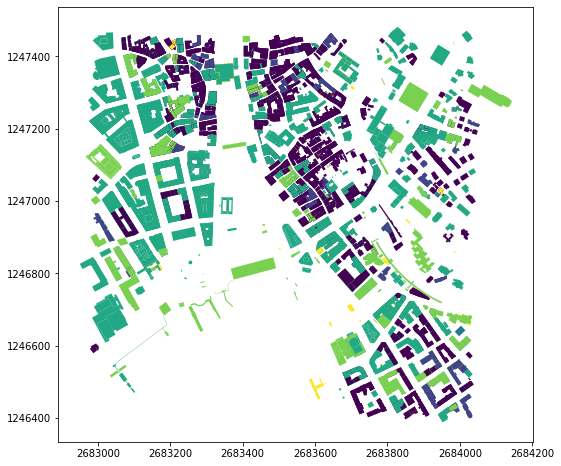

In [112]:
bld_comb.plot(column='BLDGTYP')

Now we just need to rename some columns to make it compatible with palmpy:

In [113]:
print(bld_comb[bld_comb.egid == 140856])

       adat  art       ausr bem  dach      edat      egid filt  \
0  20140925    0  BATCHUSER  OK   NaN  20090101  140856.0   08   
0  20140925    0  BATCHUSER  OK   NaN  20090101  140856.0   08   

                      gid_3d  h_boden  ...               ogid  otype  qumess  \
0  z41ac39cc00001bb0-00-0001    404.8  ...  z41ac39cc00001bb0     BB    None   
0  z41ac39cc00001bb0-00-0001    404.8  ...  z41ac39cc00001bb0     BB    None   

    sta  wichtig                                           geometry  \
0  real     None  POLYGON ((2683326.581 1247163.424, 2683326.252...   
0  real     None  POLYGON ((2683326.581 1247163.424, 2683326.252...   

  index_right   gbauj               artzh BLDGTYP  
0       589.0  1540.0      Gebäude Wohnen       1  
0       778.0  1757.0  Gebäude Verwaltung       4  

[2 rows x 26 columns]


In [114]:
bld_comb.columns

Index(['adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt', 'gid_3d',
       'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau', 'h_rel_firs',
       'h_rel_mean', 'ogid', 'otype', 'qumess', 'sta', 'wichtig', 'geometry',
       'index_right', 'gbauj', 'artzh', 'BLDGTYP'],
      dtype='object')

In [119]:
bld_comb = bld_comb.rename(columns={'h_rel_mean':'HEIGHT_TOP'})
bld_comb['HEIGHT_BOT'] = 0
bld_comb = bld_comb.reset_index()
bld_comb['ID'] = bld_comb.index

In [120]:
bld_comb.columns

Index(['index', 'adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt',
       'gid_3d', 'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau',
       'h_rel_firs', 'HEIGHT_TOP', 'ogid', 'otype', 'qumess', 'sta', 'wichtig',
       'geometry', 'index_right', 'gbauj', 'artzh', 'BLDGTYP', 'HEIGHT_BOT',
       'ID'],
      dtype='object')

Now we have it all. save the new file!

In [123]:
bld_comb.to_file(('I:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_buildings_processed.shp'))